# Bengali.AI SEResNeXt training with pytorch

I will introduce following contents

 - **Fast data loading** with feather format
 - **Data augmentation** technic with affine transformation
 - **CNN SoTA models**: Use pytorch `pretrainedmodels` library, especially I use **`SEResNeXt`** in this notebook
 - **Training code abstraction**: Use `pytorch-ignite` module for the trainining abstraction
 
### Update history

 - 2020/1/4 v2: Added albumentations augmentations introduced in [Bengali: albumentations data augmentation tutorial](https://www.kaggle.com/corochann/bengali-albumentations-data-augmentation-tutorial)

# Table of Contents:
**[Fast data loading with feather](#load)**<br>
**[Dataset](#dataset)**<br>
**[Data augmentation/processing](#processing)**<br>
**[pytorch model & define classifier](#model)**<br>
**[Training code](#train)**<br>
**[Prediction](#pred)**<br>
**[Reference and further reading](#ref)**<br>

To install https://github.com/Cadene/pretrained-models.pytorch without internet connection, we can install library as "dataset".

It is uploaded by @rishabhiitbhu : https://www.kaggle.com/rishabhiitbhu/pretrainedmodels

In [0]:
# !pip install ../input/pretrainedmodels/pretrainedmodels-0.7.4/pretrainedmodels-0.7.4/ > /dev/null # no output

In [0]:
import gc
import os
from pathlib import Path
import random
import sys

from tqdm import tqdm
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import seaborn as sns

from IPython.core.display import display, HTML

# --- plotly ---
from plotly import tools, subplots
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff

# --- models ---
from sklearn import preprocessing
from sklearn.model_selection import KFold
# import lightgbm as lgb
# import xgboost as xgb
# import catboost as cb

# --- setup ---
pd.set_option('max_columns', 50)

In [0]:
from google.colab import drive
drive.mount(mountpoint="content")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at content


In [0]:
%cd /content/content/My Drive/bengali-ai/kaggle/working

/content/content/My Drive/bengali-ai/kaggle/working


In [0]:
input_path = "/content/content/My Drive/bengali-ai/kaggle/input/"
work_path = "/content/content/My Drive/bengali-ai/kaggle/working"

In [0]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk(input_path):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/content/content/My Drive/bengali-ai/kaggle/input/bengaliaicv19feather/test_image_data_0.feather
/content/content/My Drive/bengali-ai/kaggle/input/bengaliaicv19feather/test_image_data_1.feather
/content/content/My Drive/bengali-ai/kaggle/input/bengaliaicv19feather/test_image_data_2.feather
/content/content/My Drive/bengali-ai/kaggle/input/bengaliaicv19feather/test_image_data_3.feather
/content/content/My Drive/bengali-ai/kaggle/input/bengaliaicv19feather/train_image_data_0.feather
/content/content/My Drive/bengali-ai/kaggle/input/bengaliaicv19feather/train_image_data_1.feather
/content/content/My Drive/bengali-ai/kaggle/input/bengaliaicv19feather/train_image_data_2.feather
/content/content/My Drive/bengali-ai/kaggle/input/bengaliaicv19feather/train_image_data_3.feather
/content/content/My Drive/bengali-ai/kaggle/input/bengaliai-cv19/class_map.csv
/content/content/My Drive/bengali-ai/kaggle/input/bengaliai-cv19/sample_submission.csv
/content/content/My Drive/bengali-ai/kaggle/input/beng

In [0]:
debug=False
submission=True
batch_size=256
device='cuda:0'
out='.'
image_size=64
arch='pretrained'
# model_name='se_resnext50_32x4d'
model_name = 'se_resnext101_32x4d'
outdir = work_path
max_epochs = 75
# load_model_path = False
load_model_path = outdir+"/models/predictor_101.pt"
lr = 5e-4
threshold = 30
file_num = 101

In [0]:
datadir = Path(input_path+'bengaliai-cv19')
featherdir = Path(input_path+'bengaliaicv19feather')
outdir = work_path 

In [0]:
!pip install pytorch-ignite

     |████████████████████████████████| 112kB 4.9MB/s 


In [0]:
!pip install pretrainedmodels

     |████████████████████████████████| 61kB 3.1MB/s 
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-cp36-none-any.whl size=60962 sha256=409affacbeed1649d5dcabceab597b42330fa855f49bdcd47cfd7eed0870a9f5
  Stored in directory: /root/.cache/pip/wheels/69/df/63/62583c096289713f22db605aa2334de5b591d59861a02c2ecd
Successfully built pretrainedmodels


In [0]:
!pip install albumentations

     |████████████████████████████████| 634kB 5.0MB/s 
  Created wheel for imgaug: filename=imgaug-0.2.6-cp36-none-any.whl size=654020 sha256=6406724855996b29dab7532020f136d463443ed1305c3f63a7d8f9d493f1520c
  Stored in directory: /root/.cache/pip/wheels/97/ec/48/0d25896c417b715af6236dbcef8f0bed136a1a5e52972fc6d0
Successfully built imgaug
  Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9


In [0]:
# Read in the data CSV files
# train = pd.read_csv(datadir/'train.csv')
# test = pd.read_csv(datadir/'test.csv')
# sample_submission = pd.read_csv(datadir/'sample_submission.csv')
# class_map = pd.read_csv(datadir/'class_map.csv')

# Fast data loading with feather

Refer [Bengali.AI super fast data loading with feather](https://www.kaggle.com/corochann/bengali-ai-super-fast-data-loading-with-feather) and [dataset](https://www.kaggle.com/corochann/bengaliaicv19feather) for detail.<br/>
Original `parquet` format takes about 60 sec to load 1 data, while `feather` format takes about **2 sec to load 1 data!!!**

### How to add dataset

When you write kernel, click "+ Add Data" botton on right top.<br/>
Then inside window pop-up, you can see "Search Datasets" text box on right top.<br/>
You can type "bengaliai-cv19-feather" to find this dataset and press "Add" botton to add the data.

In [0]:
def prepare_image(datadir, featherdir, data_type='train',
                  submission=False, indices=[0, 1, 2, 3]):
    assert data_type in ['train', 'test']
    if submission:
        image_df_list = [pd.read_parquet(datadir / f'{data_type}_image_data_{i}.parquet')
                         for i in indices]
    else:
        image_df_list = [pd.read_feather(featherdir / f'{data_type}_image_data_{i}.feather')
                         for i in indices]

    print('image_df_list', len(image_df_list))
    HEIGHT = 137
    WIDTH = 236
    images = [df.iloc[:, 1:].values.reshape(-1, HEIGHT, WIDTH) for df in image_df_list]
    del image_df_list
    gc.collect()
    images = np.concatenate(images, axis=0)
    return images


In [0]:
%%time

train = pd.read_csv(datadir/'train.csv')
train_labels = train[['grapheme_root', 'vowel_diacritic', 'consonant_diacritic']].values
indices = [0] if debug else [0, 1, 2, 3]
train_images = prepare_image(
    datadir, featherdir, data_type='train', submission=submission, indices=indices)
print(train_images.shape)

image_df_list 4
(200840, 137, 236)
CPU times: user 1min 4s, sys: 23.2 s, total: 1min 27s
Wall time: 2min 2s


# GridMask

In [0]:
import cv2

import albumentations
from albumentations.core.transforms_interface import DualTransform
from albumentations.augmentations import functional as FF
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader, Dataset

class GridMask(DualTransform):
    """GridMask augmentation for image classification and object detection.
    
    Author: Qishen Ha
    Email: haqishen@gmail.com
    2020/01/29

    Args:
        num_grid (int): number of grid in a row or column.
        fill_value (int, float, lisf of int, list of float): value for dropped pixels.
        rotate ((int, int) or int): range from which a random angle is picked. If rotate is a single int
            an angle is picked from (-rotate, rotate). Default: (-90, 90)
        mode (int):
            0 - cropout a quarter of the square of each grid (left top)
            1 - reserve a quarter of the square of each grid (left top)
            2 - cropout 2 quarter of the square of each grid (left top & right bottom)

    Targets:
        image, mask

    Image types:
        uint8, float32

    Reference:
    |  https://arxiv.org/abs/2001.04086
    |  https://github.com/akuxcw/GridMask
    """

    def __init__(self, num_grid=3, fill_value=0, rotate=0, mode=0, always_apply=False, p=0.5):
        super(GridMask, self).__init__(always_apply, p)
        if isinstance(num_grid, int):
            num_grid = (num_grid, num_grid)
        if isinstance(rotate, int):
            rotate = (-rotate, rotate)
        self.num_grid = num_grid
        self.fill_value = fill_value
        self.rotate = rotate
        self.mode = mode
        self.masks = None
        self.rand_h_max = []
        self.rand_w_max = []

    def init_masks(self, height, width):
        if self.masks is None:
            self.masks = []
            n_masks = self.num_grid[1] - self.num_grid[0] + 1
            for n, n_g in enumerate(range(self.num_grid[0], self.num_grid[1] + 1, 1)):
                grid_h = height / n_g
                grid_w = width / n_g
                this_mask = np.ones((int((n_g + 1) * grid_h), int((n_g + 1) * grid_w))).astype(np.uint8)
                for i in range(n_g + 1):
                    for j in range(n_g + 1):
                        this_mask[
                             int(i * grid_h) : int(i * grid_h + grid_h / 2),
                             int(j * grid_w) : int(j * grid_w + grid_w / 2)
                        ] = self.fill_value
                        if self.mode == 2:
                            this_mask[
                                 int(i * grid_h + grid_h / 2) : int(i * grid_h + grid_h),
                                 int(j * grid_w + grid_w / 2) : int(j * grid_w + grid_w)
                            ] = self.fill_value
                
                if self.mode == 1:
                    this_mask = 1 - this_mask

                self.masks.append(this_mask)
                self.rand_h_max.append(grid_h)
                self.rand_w_max.append(grid_w)

    def apply(self, image, mask, rand_h, rand_w, angle, **params):
        h, w = image.shape[:2]
        mask = FF.rotate(mask, angle) if self.rotate[1] > 0 else mask
        mask = mask[:,:,np.newaxis] if image.ndim == 3 else mask
        image *= mask[rand_h:rand_h+h, rand_w:rand_w+w].astype(image.dtype)
        return image

    def get_params_dependent_on_targets(self, params):
        img = params['image']
        height, width = img.shape[:2]
        self.init_masks(height, width)

        mid = np.random.randint(len(self.masks))
        mask = self.masks[mid]
        rand_h = np.random.randint(self.rand_h_max[mid])
        rand_w = np.random.randint(self.rand_w_max[mid])
        angle = np.random.randint(self.rotate[0], self.rotate[1]) if self.rotate[1] > 0 else 0

        return {'mask': mask, 'rand_h': rand_h, 'rand_w': rand_w, 'angle': angle}

    @property
    def targets_as_params(self):
        return ['image']

    def get_transform_init_args_names(self):
        return ('num_grid', 'fill_value', 'rotate', 'mode')

<a id="dataset"></a>
# Dataset

In [0]:
"""
Referenced `chainer.dataset.DatasetMixin` to work with pytorch Dataset.
"""
import numpy
import six
import torch
from torch.utils.data.dataset import Dataset


class DatasetMixin(Dataset):

    def __init__(self, transform=None):
        self.transform = transform

    def __getitem__(self, index):
        """Returns an example or a sequence of examples."""
        if torch.is_tensor(index):
            index = index.tolist()
        if isinstance(index, slice):
            current, stop, step = index.indices(len(self))
            return [self.get_example_wrapper(i) for i in
                    six.moves.range(current, stop, step)]
        elif isinstance(index, list) or isinstance(index, numpy.ndarray):
            return [self.get_example_wrapper(i) for i in index]
        else:
            return self.get_example_wrapper(index)

    def __len__(self):
        """Returns the number of data points."""
        raise NotImplementedError

    def get_example_wrapper(self, i):
        """Wrapper of `get_example`, to apply `transform` if necessary"""
        example = self.get_example(i)
        if self.transform:
            example = self.transform(example)
        return example

    def get_example(self, i):
        """Returns the i-th example.

        Implementations should override it. It should raise :class:`IndexError`
        if the index is invalid.

        Args:
            i (int): The index of the example.

        Returns:
            The i-th example.

        """
        raise NotImplementedError


This `DatasetMixin` class can be used to define any custom dataset class in pytorch. We can implement `get_example(self, i)` method to return `i`-th data.

Here I return i-th image `x` and `label`, with scaling image to be value ranges between 0~1.

In [0]:
class BengaliAIDataset(DatasetMixin):
    def __init__(self, images, labels=None, transform=None, indices=None):
        super(BengaliAIDataset, self).__init__(transform=transform)
        self.images = images
        self.labels = labels
        if indices is None:
            indices = np.arange(len(images))
        self.indices = indices
        self.train = labels is not None

    def __len__(self):
        """return length of this dataset"""
        return len(self.indices)

    def get_example(self, i):
        """Return i-th data"""
        i = self.indices[i]
        x = self.images[i]
        # Opposite white and black: background will be white and
        # for future Affine transformation
        x = (255 - x).astype(np.float32) / 255.
        if self.train:
            y = self.labels[i]
            return x, y
        else:
            return x


Let's see how this `BengaliAIDataset` work

In [0]:
train_dataset = BengaliAIDataset(train_images, train_labels)

In [0]:
train_dataset[0]

(array([[0.00392157, 0.00784314, 0.01176471, ..., 0.00392157, 0.00784314,
         0.01568628],
        [0.        , 0.00784314, 0.00784314, ..., 0.00392157, 0.00784314,
         0.01176471],
        [0.        , 0.        , 0.        , ..., 0.00392157, 0.00392157,
         0.00784314],
        ...,
        [0.00392157, 0.00392157, 0.00784314, ..., 0.00784314, 0.00392157,
         0.01176471],
        [0.00392157, 0.00392157, 0.00392157, ..., 0.00784314, 0.00784314,
         0.01176471],
        [0.00392157, 0.00392157, 0.00392157, ..., 0.00784314, 0.00784314,
         0.01568628]], dtype=float32), array([15,  9,  5]))

`train_dataset[i]` returns i-th image array and 3 target labels (graphme_root, vowel_diacritic and consonant_diacritic).

In [0]:
image, label = train_dataset[0]
print('image', image.shape, 'label', label)

image (137, 236) label [15  9  5]


30it [00:00, 714.28it/s]


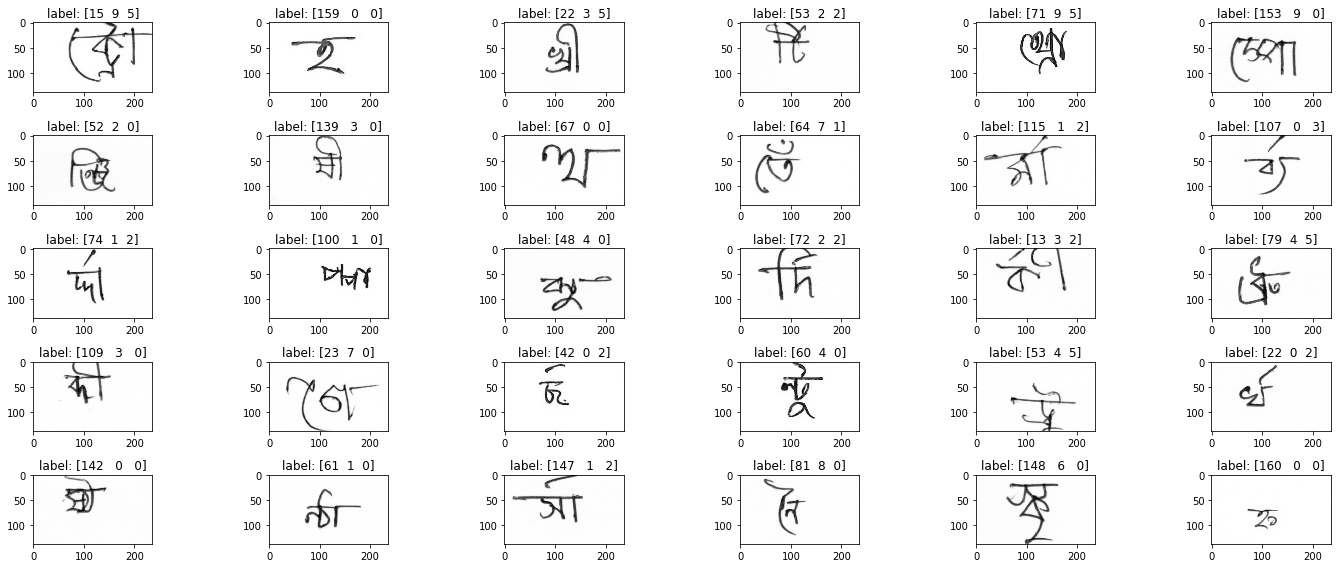

In [0]:
nrow, ncol = 5, 6

fig, axes = plt.subplots(nrow, ncol, figsize=(20, 8))
axes = axes.flatten()
for i, ax in tqdm(enumerate(axes)):
    image, label = train_dataset[i]
    ax.imshow(image, cmap='Greys')
    ax.set_title(f'label: {label}')
plt.tight_layout()
plt.show()
# plt.savefig('bengaliai.png')

<a id="processing"></a>
# Data augmentation/processing

For CNN training, data augmentation is important to improve test accuracy (generalization performance). I will show some image preprocessing to increase the data variety.

In [0]:
"""
From https://www.kaggle.com/corochann/deep-learning-cnn-with-chainer-lb-0-99700
"""
import cv2
from skimage.transform import AffineTransform, warp
import numpy as np


def affine_image(img):
    """

    Args:
        img: (h, w) or (1, h, w)

    Returns:
        img: (h, w)
    """
    # ch, h, w = img.shape
    # img = img / 255.
    if img.ndim == 3:
        img = img[0]

    # --- scale ---
    min_scale = 0.8
    max_scale = 1.2
    sx = np.random.uniform(min_scale, max_scale)
    sy = np.random.uniform(min_scale, max_scale)

    # --- rotation ---
    max_rot_angle = 7
    rot_angle = np.random.uniform(-max_rot_angle, max_rot_angle) * np.pi / 180.

    # --- shear ---
    max_shear_angle = 10
    shear_angle = np.random.uniform(-max_shear_angle, max_shear_angle) * np.pi / 180.

    # --- translation ---
    max_translation = 4
    tx = np.random.randint(-max_translation, max_translation)
    ty = np.random.randint(-max_translation, max_translation)

    tform = AffineTransform(scale=(sx, sy), rotation=rot_angle, shear=shear_angle,
                            translation=(tx, ty))
    transformed_image = warp(img, tform)
    assert transformed_image.ndim == 2
    return transformed_image


def crop_char_image(image, threshold=5./255.):
    assert image.ndim == 2
    is_black = image > threshold

    is_black_vertical = np.sum(is_black, axis=0) > 0
    is_black_horizontal = np.sum(is_black, axis=1) > 0
    left = np.argmax(is_black_horizontal)
    right = np.argmax(is_black_horizontal[::-1])
    top = np.argmax(is_black_vertical)
    bottom = np.argmax(is_black_vertical[::-1])
    height, width = image.shape
    cropped_image = image[left:height - right, top:width - bottom]
    return cropped_image


def resize(image, size=(128, 128)):
    return cv2.resize(image, size)

## Affine transformation for data augmentation

To increase validation score, the number of training data is important. When we can use more number of training data, we can reduce overfitting and validation score becomes high.

"Data augmentation" is a technic to virtually create extra training data, based on the given training data. For this MNIST task, data augmentation can be achieved by utilizing affine transformation.

1. Rotation AffineTransformation
2. Translation
3. Scale
4. Shear

6it [00:00, 241.02it/s]


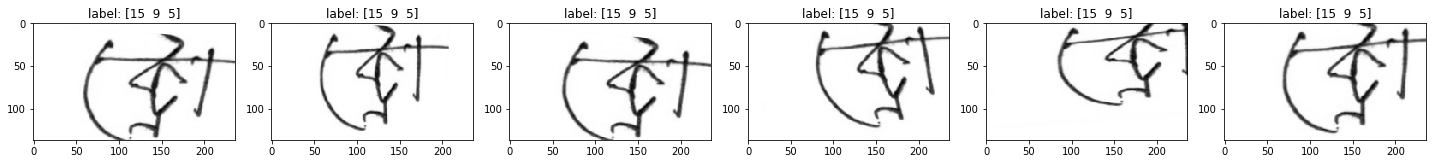

In [0]:
nrow, ncol = 1, 6

fig, axes = plt.subplots(nrow, ncol, figsize=(20, 8))
axes = axes.flatten()
for i, ax in tqdm(enumerate(axes)):
    image, label = train_dataset[0]
    ax.imshow(affine_image(image), cmap='Greys')
    ax.set_title(f'label: {label}')
plt.tight_layout()

When the image is slightly rotated, shifted (transformed) or scaled, the image looks like the same label. We can virtually create another image data from one image in such a way.

## crop image

Here I crop image

30it [00:00, 705.45it/s]


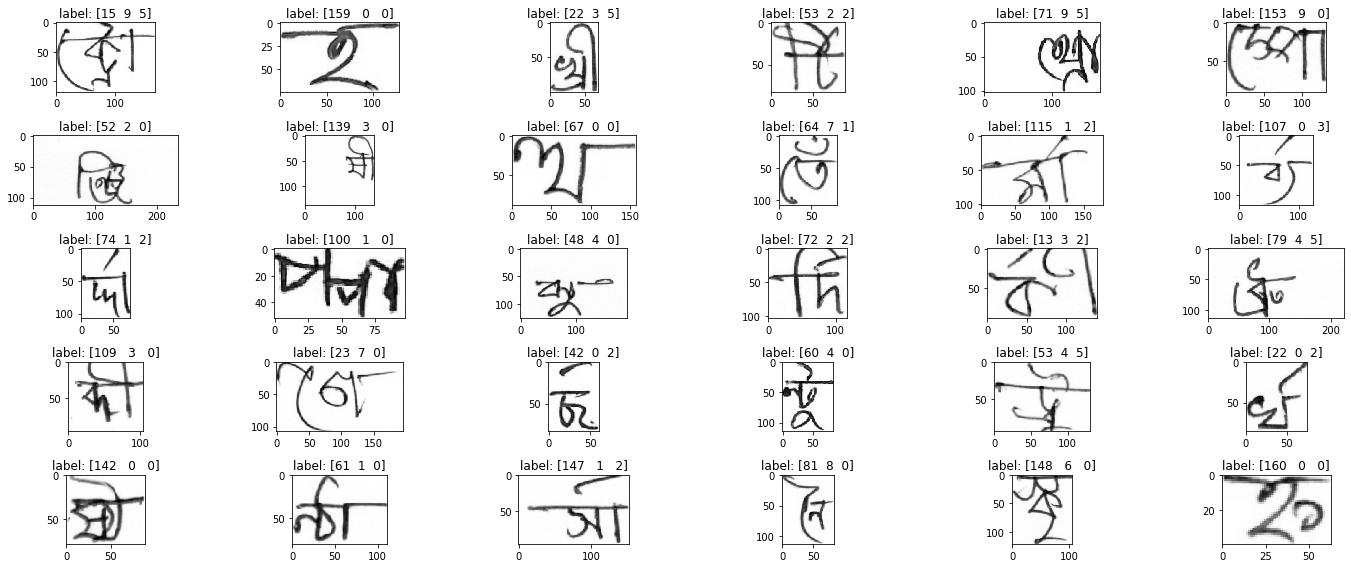

In [0]:
nrow, ncol = 5, 6

fig, axes = plt.subplots(nrow, ncol, figsize=(20, 8))
axes = axes.flatten()
for i, ax in tqdm(enumerate(axes)):
    image, label = train_dataset[i]
    ax.imshow(crop_char_image(image, threshold=20./255.), cmap='Greys')
    ax.set_title(f'label: {label}')
plt.tight_layout()

## resize image

We need to resize image after crop, to align image size for CNN batch training.

30it [00:00, 434.98it/s]


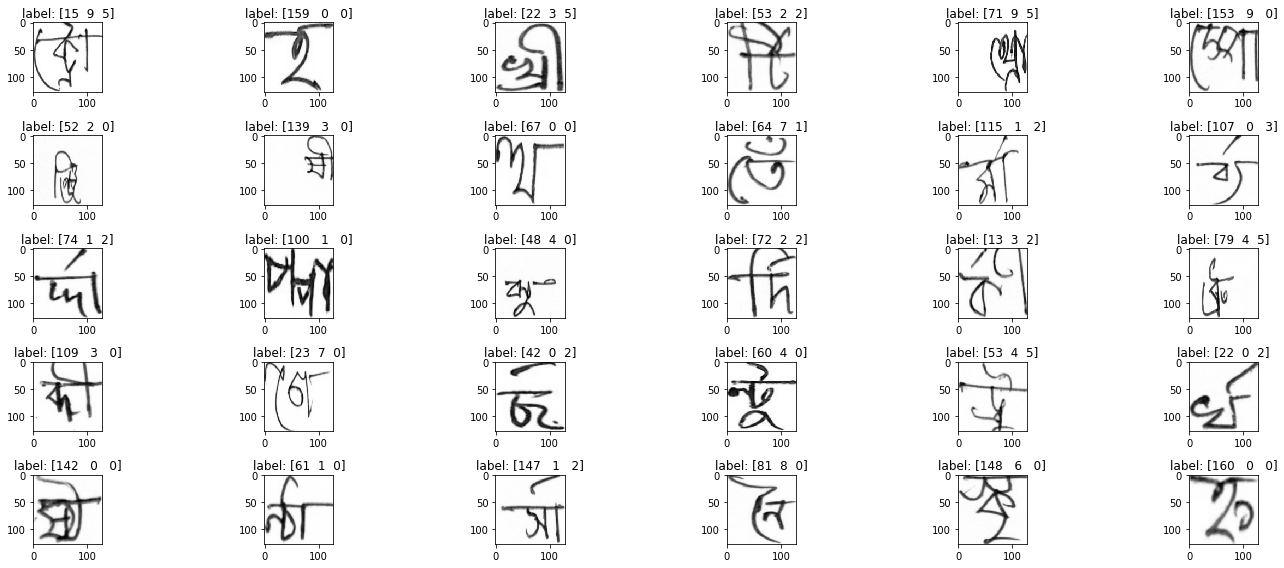

In [0]:
nrow, ncol = 5, 6

fig, axes = plt.subplots(nrow, ncol, figsize=(20, 8))
axes = axes.flatten()
for i, ax in tqdm(enumerate(axes)):
    image, label = train_dataset[i]
    ax.imshow(resize(crop_char_image(image, threshold=20./255.)), cmap='Greys')
    ax.set_title(f'label: {label}')
plt.tight_layout()

In [0]:
!pip install -U git+https://github.com/albu/albumentations > /dev/null && echo "All libraries are successfully installed!"

  Running command git clone -q https://github.com/albu/albumentations /tmp/pip-req-build-dvqh6yaw
All libraries are successfully installed!


Put everything together with `Transform` class. <br>
[Update] I added **albumentations augmentations** introduced in [Bengali: albumentations data augmentation tutorial](https://www.kaggle.com/corochann/bengali-albumentations-data-augmentation-tutorial).

In [0]:
import albumentations.augmentations.transforms as A
import albumentations
import numpy as np
from albumentations import (VerticalFlip, HorizontalFlip, Flip, RandomRotate90, Rotate, ShiftScaleRotate, CenterCrop, OpticalDistortion, GridDistortion, ElasticTransform, JpegCompression, HueSaturationValue,
                            RGBShift, RandomBrightness, RandomContrast, Blur, MotionBlur, MedianBlur, GaussNoise, CLAHE, ChannelShuffle, InvertImg, RandomGamma, ToGray, PadIfNeeded ,
                           )


def add_gaussian_noise(x, sigma):
    x += np.random.randn(*x.shape) * sigma
    x = np.clip(x, 0., 1.)
    return x


def _evaluate_ratio(ratio):
    if ratio <= 0.:
        return False
    return np.random.uniform() < ratio


def apply_aug(aug, image):
    return aug(image=image)['image']


class Transform:
    def __init__(self, affine=True, crop=True, size=(64, 64),
                 normalize=True, train=True, threshold=40.,
                 sigma=-1., blur_ratio=0., noise_ratio=0., cutout_ratio=0.,
                 grid_distortion_ratio=0., elastic_distortion_ratio=0., random_brightness_ratio=0.,
                 piece_affine_ratio=0., ssr_ratio=0., gridmask=None):
        self.affine = affine
        self.crop = crop
        self.size = size
        self.normalize = normalize
        self.train = train
        self.threshold = threshold / 255.
        self.sigma = sigma / 255.

        self.blur_ratio = blur_ratio
        self.noise_ratio = noise_ratio
        self.cutout_ratio = cutout_ratio
        self.grid_distortion_ratio = grid_distortion_ratio
        self.elastic_distortion_ratio = elastic_distortion_ratio
        self.random_brightness_ratio = random_brightness_ratio
        self.piece_affine_ratio = piece_affine_ratio
        self.ssr_ratio = ssr_ratio
        self.gridmask = gridmask

    def __call__(self, example):
        if self.train:
            x, y = example
        else:
            x = example
        # --- Augmentation ---
        if self.affine:
            x = affine_image(x)

        # --- Train/Test common preprocessing ---
        if self.crop:
            x = crop_char_image(x, threshold=self.threshold)
        if self.size is not None:
            x = resize(x, size=self.size)
        if self.sigma > 0.:
            x = add_gaussian_noise(x, sigma=self.sigma)

        # albumentations...

        

        x = x.astype(np.float32)
        assert x.ndim == 2
        # 1. blur
        if _evaluate_ratio(self.blur_ratio):
            r = np.random.uniform()
            if r < 0.25:
                x = apply_aug(Blur(p=1.0), x)
            elif r < 0.5:
                x = apply_aug(MedianBlur(blur_limit=5, p=1.0), x)
            elif r < 0.75:
                x = apply_aug(A.GaussianBlur(p=1.0), x)
            else:
                x = apply_aug(MotionBlur(p=1.0), x)

        if _evaluate_ratio(self.noise_ratio):
            r = np.random.uniform()
            if r < 0.50:
                x = apply_aug(GaussNoise(var_limit=5. / 255., p=1.0), x)
            else:
                x = apply_aug(A.MultiplicativeNoise(p=1.0), x)

        if _evaluate_ratio(self.cutout_ratio):
            # A.Cutout(num_holes=2,  max_h_size=2, max_w_size=2, p=1.0)  # Deprecated...
            x = apply_aug(A.CoarseDropout(max_holes=8, max_height=8, max_width=8, p=1.0), x)

        if _evaluate_ratio(self.grid_distortion_ratio):
            x = apply_aug(A.GridDistortion(p=1.0), x)

        if _evaluate_ratio(self.elastic_distortion_ratio):
            x = apply_aug(ElasticTransform(
                sigma=50, alpha=1, alpha_affine=10, p=1.0), x)

        if _evaluate_ratio(self.random_brightness_ratio):
            # A.RandomBrightness(p=1.0)  # Deprecated...
            # A.RandomContrast(p=1.0)    # Deprecated...
            x = apply_aug(A.RandomBrightnessContrast(p=1.0), x)

        if _evaluate_ratio(self.piece_affine_ratio):
            x = apply_aug(albumentations.imgaug.transforms.IAAPiecewiseAffine(p=1.0), x)

        if _evaluate_ratio(self.ssr_ratio):
            x = apply_aug(A.ShiftScaleRotate(
                shift_limit=0.0625,
                scale_limit=0.1,
                rotate_limit=30,
                p=1.0), x)
        
        if self.gridmask is not None:#追加はじまり
            #print("albumentation変換開始")
            res = self.gridmask(image=x)
            x = res['image'].astype(np.float32)

        if self.normalize:
            x = (x.astype(np.float32) - 0.0692) / 0.2051
        if x.ndim == 2:
            x = x[None, :, :]

        
        x = x.astype(np.float32)
        if self.train:
            y = y.astype(np.int64)
            return x, y
        else:
            return x

In [0]:
gridmask = albumentations.Compose([
    albumentations.OneOf([
        GridMask(num_grid=(3,4), mode=0, rotate=15),
        #GridMask(num_grid=(6,7), mode=1),
        #GridMask(num_grid=(6,7), mode=2),
    ], p=0.5)
])

train_transform = Transform(
    size=(image_size, image_size), threshold=20.,
    sigma=-1., blur_ratio=0, noise_ratio=0, cutout_ratio=0,
    grid_distortion_ratio=0.02, random_brightness_ratio=0.02,
    piece_affine_ratio=0.02, ssr_ratio=0.20,gridmask=gridmask)
# transform = Transform(size=(image_size, image_size)

train_dataset = BengaliAIDataset(train_images, train_labels,
                                 transform=train_transform)

In [0]:
train_dataset[0]

(array([[[-0.31974965, -0.31827614, -0.31827614, ..., -0.3373964 ,
          -0.3373964 , -0.3373964 ],
         [-0.3339445 , -0.32996964, -0.31827614, ..., -0.3373964 ,
          -0.3373964 , -0.3373964 ],
         [-0.3251944 , -0.33511052, -0.3160038 , ..., -0.3373964 ,
          -0.3373964 , -0.3373964 ],
         ...,
         [-0.3373964 , -0.3373964 , -0.3373964 , ..., -0.3373964 ,
          -0.3373964 , -0.3373964 ],
         [-0.3373964 , -0.3373964 , -0.3373964 , ..., -0.3373964 ,
          -0.3373964 , -0.3373964 ],
         [-0.3373964 , -0.3373964 , -0.3373964 , ..., -0.3373964 ,
          -0.3373964 , -0.3373964 ]]], dtype=float32), array([15,  9,  5]))

(array([3076.,  112.,   83.,   72.,   65.,   49.,   41.,   53.,   34.,
          38.,   48.,   50.,   64.,   67.,   61.,   61.,   54.,   30.,
          32.,    6.]),
 array([-0.3373964 , -0.1252872 ,  0.086822  ,  0.2989312 ,  0.51104045,
         0.72314966,  0.93525887,  1.1473681 ,  1.3594773 ,  1.5715865 ,
         1.7836957 ,  1.9958049 ,  2.207914  ,  2.4200232 ,  2.6321325 ,
         2.8442416 ,  3.056351  ,  3.26846   ,  3.4805694 ,  3.6926785 ,
         3.9047878 ], dtype=float32),
 <a list of 20 Patch objects>)

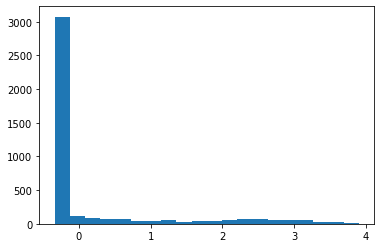

In [0]:
plt.hist(train_dataset[0][0].reshape(-1,1), bins=20)

By setting `transform`, its function is called **every time** when we access to the index. Dataset returns different `image` every time! which is useful for training with data augmentation.

6it [00:00, 354.86it/s]


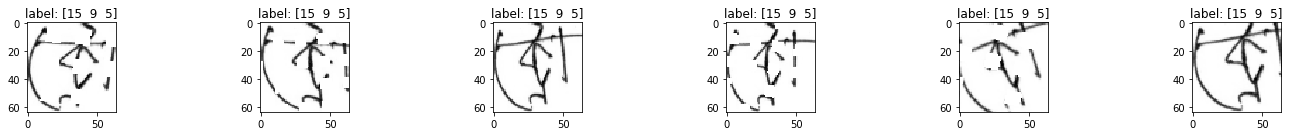

In [0]:
nrow, ncol = 1, 6

fig, axes = plt.subplots(nrow, ncol, figsize=(20, 2))
axes = axes.flatten()
for i, ax in tqdm(enumerate(axes)):
    image, label = train_dataset[0]
    ax.imshow(image[0], cmap='Greys')
    ax.set_title(f'label: {label}')
plt.tight_layout()

Let's final check the processed images, which will be trained by the model.

30it [00:00, 221.66it/s]


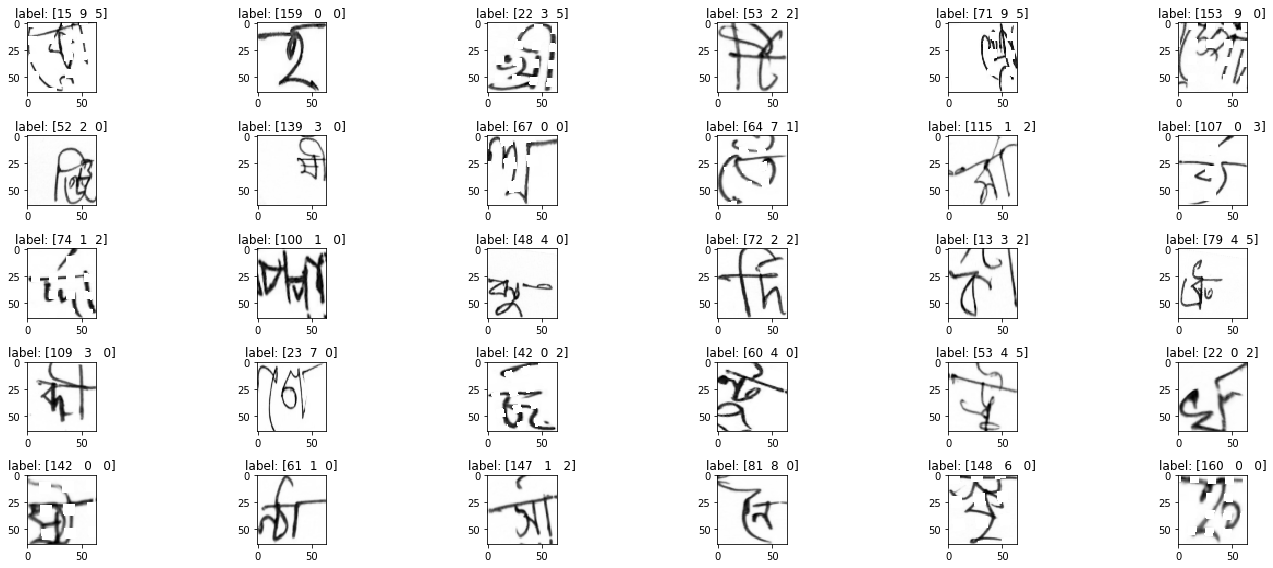

In [0]:
nrow, ncol = 5, 6

fig, axes = plt.subplots(nrow, ncol, figsize=(20, 8))
axes = axes.flatten()
for i, ax in tqdm(enumerate(axes)):
    #print(i)
    image, label = train_dataset[i]
    ax.imshow(image[0], cmap='Greys')
    ax.set_title(f'label: {label}')
plt.tight_layout()

In [0]:
i

29

<a id="model"></a> 
# pytorch model & define classifier

In [0]:
import torch


def residual_add(lhs, rhs):
    lhs_ch, rhs_ch = lhs.shape[1], rhs.shape[1]
    if lhs_ch < rhs_ch:
        out = lhs + rhs[:, :lhs_ch]
    elif lhs_ch > rhs_ch:
        out = torch.cat([lhs[:, :rhs_ch] + rhs, lhs[:, rhs_ch:]], dim=1)
    else:
        out = lhs + rhs
    return out


In [0]:
from typing import List

import torch
from torch import nn
from torch.nn.parameter import Parameter


class LazyLoadModule(nn.Module):
    """Lazy buffer/parameter loading using load_state_dict_pre_hook

    Define all buffer/parameter in `_lazy_buffer_keys`/`_lazy_parameter_keys` and
    save buffer with `register_buffer`/`register_parameter`
    method, which can be outside of __init__ method.
    Then this module can load any shape of Tensor during de-serializing.

    Note that default value of lazy buffer is torch.Tensor([]), while lazy parameter is None.
    """
    _lazy_buffer_keys: List[str] = []     # It needs to be override to register lazy buffer
    _lazy_parameter_keys: List[str] = []  # It needs to be override to register lazy parameter

    def __init__(self):
        super(LazyLoadModule, self).__init__()
        for k in self._lazy_buffer_keys:
            self.register_buffer(k, torch.tensor([]))
        for k in self._lazy_parameter_keys:
            self.register_parameter(k, None)
        self._register_load_state_dict_pre_hook(self._hook)

    def _hook(self, state_dict, prefix, local_metadata, strict, missing_keys,
             unexpected_keys, error_msgs):
        for key in self._lazy_buffer_keys:
            self.register_buffer(key, state_dict[prefix + key])

        for key in self._lazy_parameter_keys:
            self.register_parameter(key, Parameter(state_dict[prefix + key]))


In [0]:
import math
import torch
from torch.nn import init
from torch.nn.parameter import Parameter
import torch.nn.functional as F


class LazyLinear(LazyLoadModule):
    """Linear module with lazy input inference

    `in_features` can be `None`, and it is determined at the first time of forward step dynamically.
    """

    __constants__ = ['bias', 'in_features', 'out_features']
    _lazy_parameter_keys = ['weight']

    def __init__(self, in_features, out_features, bias=True):
        super(LazyLinear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        if bias:
            self.bias = Parameter(torch.Tensor(out_features))
        else:
            self.register_parameter('bias', None)

        if in_features is not None:
            self.weight = Parameter(torch.Tensor(out_features, in_features))
            self.reset_parameters()

    def reset_parameters(self):
        init.kaiming_uniform_(self.weight, a=math.sqrt(5))
        if self.bias is not None:
            fan_in, _ = init._calculate_fan_in_and_fan_out(self.weight)
            bound = 1 / math.sqrt(fan_in)
            init.uniform_(self.bias, -bound, bound)

    def forward(self, input):
        if self.weight is None:
            self.in_features = input.shape[-1]
            self.weight = Parameter(torch.Tensor(self.out_features, self.in_features))
            self.reset_parameters()

            # Need to send lazy defined parameter to device...
            self.to(input.device)
        return F.linear(input, self.weight, self.bias)

    def extra_repr(self):
        return 'in_features={}, out_features={}, bias={}'.format(
            self.in_features, self.out_features, self.bias is not None
        )


In [0]:
from torch import nn
import torch.nn.functional as F


class LinearBlock(nn.Module):

    def __init__(self, in_features, out_features, bias=True,
                 use_bn=True, activation=F.relu, dropout_ratio=-1, residual=False,):
        super(LinearBlock, self).__init__()
        if in_features is None:
            self.linear = LazyLinear(in_features, out_features, bias=bias)
        else:
            self.linear = nn.Linear(in_features, out_features, bias=bias)
        if use_bn:
            self.bn = nn.BatchNorm1d(out_features)
        if dropout_ratio > 0.:
            self.dropout = nn.Dropout(p=dropout_ratio)
        else:
            self.dropout = None
        self.activation = activation
        self.use_bn = use_bn
        self.dropout_ratio = dropout_ratio
        self.residual = residual

    def __call__(self, x):
        h = self.linear(x)
        if self.use_bn:
            h = self.bn(h)
        if self.activation is not None:
            h = self.activation(h)
        if self.residual:
            h = residual_add(h, x)
        if self.dropout_ratio > 0:
            h = self.dropout(h)
        return h

In [0]:
import pretrainedmodels
import torch
from torch import nn
import torch.nn.functional as F
from torch.nn import Sequential


class PretrainedCNN(nn.Module):
    def __init__(self, model_name='se_resnext101_32x4d',
                 in_channels=1, out_dim=10, use_bn=True,
                 pretrained='imagenet'):
        super(PretrainedCNN, self).__init__()
        self.conv0 = nn.Conv2d(
            in_channels, 3, kernel_size=3, stride=1, padding=1, bias=True)
        self.base_model = pretrainedmodels.__dict__[model_name](pretrained=pretrained)
        activation = F.leaky_relu
        self.do_pooling = True
        if self.do_pooling:
            inch = self.base_model.last_linear.in_features
        else:
            inch = None
        hdim = 512
        lin1 = LinearBlock(inch, hdim, use_bn=use_bn, activation=activation, residual=False)
        lin2 = LinearBlock(hdim, out_dim, use_bn=use_bn, activation=None, residual=False)
        self.lin_layers = Sequential(lin1, lin2)

    def forward(self, x):
        h = self.conv0(x)
        h = self.base_model.features(h)

        if self.do_pooling:
            h = torch.sum(h, dim=(-1, -2))
        else:
            # [128, 2048, 4, 4] when input is (128, 128)
            bs, ch, height, width = h.shape
            h = h.view(bs, ch*height*width)
        for layer in self.lin_layers:
            h = layer(h)
        return h

## Classifier

In [0]:
import torch
from torch import nn
import torch.nn.functional as F
from tqdm import tqdm


def accuracy(y, t):
    pred_label = torch.argmax(y, dim=1)
    count = pred_label.shape[0]
    correct = (pred_label == t).sum().type(torch.float32)
    acc = correct / count
    return acc


class BengaliClassifier(nn.Module):
    def __init__(self, predictor, n_grapheme=168, n_vowel=11, n_consonant=7):
        super(BengaliClassifier, self).__init__()
        self.n_grapheme = n_grapheme
        self.n_vowel = n_vowel
        self.n_consonant = n_consonant
        self.n_total_class = self.n_grapheme + self.n_vowel + self.n_consonant
        self.predictor = predictor

        self.metrics_keys = [
            'loss', 'loss_grapheme', 'loss_vowel', 'loss_consonant',
            'acc_grapheme', 'acc_vowel', 'acc_consonant']

    def forward(self, x, y=None):
        pred = self.predictor(x)
        if isinstance(pred, tuple):
            assert len(pred) == 3
            preds = pred
        else:
            assert pred.shape[1] == self.n_total_class
            preds = torch.split(pred, [self.n_grapheme, self.n_vowel, self.n_consonant], dim=1)
        loss_grapheme = F.cross_entropy(preds[0], y[:, 0])
        loss_vowel = F.cross_entropy(preds[1], y[:, 1])
        loss_consonant = F.cross_entropy(preds[2], y[:, 2])
        loss = loss_grapheme + loss_vowel + loss_consonant
        metrics = {
            'loss': loss.item(),
            'loss_grapheme': loss_grapheme.item(),
            'loss_vowel': loss_vowel.item(),
            'loss_consonant': loss_consonant.item(),
            'acc_grapheme': accuracy(preds[0], y[:, 0]),
            'acc_vowel': accuracy(preds[1], y[:, 1]),
            'acc_consonant': accuracy(preds[2], y[:, 2]),
        }
        return loss, metrics, pred

    def calc(self, data_loader):
        device: torch.device = next(self.parameters()).device
        self.eval()
        output_list = []
        with torch.no_grad():
            for batch in tqdm(data_loader):
                # TODO: support general preprocessing.
                # If `data` is not `Data` instance, `to` method is not supported!
                batch = batch.to(device)
                pred = self.predictor(batch)
                output_list.append(pred)
        output = torch.cat(output_list, dim=0)
        preds = torch.split(output, [self.n_grapheme, self.n_vowel, self.n_consonant], dim=1)
        return preds

    def predict_proba(self, data_loader):
        preds = self.calc(data_loader)
        return [F.softmax(p, dim=1) for p in preds]

    def predict(self, data_loader):
        preds = self.calc(data_loader)
        pred_labels = [torch.argmax(p, dim=1) for p in preds]
        return pred_labels


<a id="train"></a>
# Training code

## prepare data

In [0]:
gridmask = albumentations.Compose([
    albumentations.OneOf([
        GridMask(num_grid=(3,4), mode=0, rotate=15),
        GridMask(num_grid=(3,4), mode=1, rotate=15),
        #GridMask(num_grid=(4,5), mode=2, rotate=15),
    ], p=0.5)
])

train_transform = Transform(
    size=(image_size, image_size), threshold=threshold,
    sigma=-1., blur_ratio=0, noise_ratio=0, cutout_ratio=0,
    grid_distortion_ratio=0.02, random_brightness_ratio=0.02,
    piece_affine_ratio=0.2, ssr_ratio=0.20,gridmask=gridmask)


valid_transform = Transform(affine=True, crop=True, size=(image_size, image_size))

In [0]:
n_dataset = len(train_images)
train_data_size = 200 if debug else int(n_dataset * 0.9)
valid_data_size = 100 if debug else int(n_dataset - train_data_size)

perm = np.random.RandomState(774).permutation(n_dataset)
print('perm', perm)
train_dataset = BengaliAIDataset(
    train_images, train_labels, transform=train_transform ,
    indices=perm[:train_data_size])
valid_dataset = BengaliAIDataset(
    train_images, train_labels, transform=valid_transform,
    indices=perm[train_data_size:train_data_size+valid_data_size])
print('train_dataset', len(train_dataset), 'valid_dataset', len(valid_dataset))


perm [ 74751  30698  69868 ...  63725 116040  44110]
train_dataset 180756 valid_dataset 20084


In [0]:
# --- Model ---
device = torch.device(device)
n_grapheme = 168
n_vowel = 11
n_consonant = 7
n_total = n_grapheme + n_vowel + n_consonant
print('n_total', n_total)
# Set pretrained='imagenet' to download imagenet pretrained model...
predictor = PretrainedCNN(in_channels=1, out_dim=n_total, model_name=model_name, pretrained=None)
if load_model_path:
    predictor.load_state_dict(torch.load(load_model_path))

print('predictor', type(predictor))
#print(predictor)
classifier = BengaliClassifier(predictor).to(device)

n_total 186
predictor <class '__main__.PretrainedCNN'>


## Ignite utility

pytorch-ignite utility class for training

In [0]:
import json
from logging import getLogger
import numpy

def save_json(filepath, params):
    with open(filepath, 'w') as f:
        json.dump(params, f, indent=4)

In [0]:
import os
from logging import getLogger
from time import perf_counter

import pandas as pd
import torch
# from chainer_chemistry.utils import save_json

from ignite.engine.engine import Engine, Events
from ignite.metrics import Average


class DictOutputTransform:
    def __init__(self, key, index=0):
        self.key = key
        self.index = index

    def __call__(self, x):
        if self.index >= 0:
            x = x[self.index]
        return x[self.key]


def create_trainer(classifier, optimizer, device):
    classifier.to(device)

    def update_fn(engine, batch):
        classifier.train()
        optimizer.zero_grad()
        # batch = [elem.to(device) for elem in batch]
        x, y = [elem.to(device) for elem in batch]
        loss, metrics, pred_y = classifier(x, y)
        loss.backward()
        optimizer.step()
        return metrics, pred_y, y
    trainer = Engine(update_fn)

    for key in classifier.metrics_keys:
        Average(output_transform=DictOutputTransform(key)).attach(trainer, key)
    return trainer


def create_evaluator(classifier, device):
    classifier.to(device)

    def update_fn(engine, batch):
        classifier.eval()
        with torch.no_grad():
            # batch = [elem.to(device) for elem in batch]
            x, y = [elem.to(device) for elem in batch]
            _, metrics, pred_y = classifier(x, y)
            return metrics, pred_y, y
    evaluator = Engine(update_fn)

    for key in classifier.metrics_keys:
        Average(output_transform=DictOutputTransform(key)).attach(evaluator, key)
    return evaluator


class LogReport:
    def __init__(self, evaluator=None, dirpath=None, logger=None):
        self.evaluator = evaluator
        self.dirpath = str(dirpath) if dirpath is not None else None
        self.logger = logger or getLogger(__name__)

        self.reported_dict = {}  # To handle additional parameter to monitor
        self.history = []
        self.start_time = perf_counter()

    def report(self, key, value):
        self.reported_dict[key] = value

    def __call__(self, engine):
        elapsed_time = perf_counter() - self.start_time
        elem = {'epoch': engine.state.epoch,
                'iteration': engine.state.iteration}
        elem.update({f'train/{key}': value
                     for key, value in engine.state.metrics.items()})
        if self.evaluator is not None:
            elem.update({f'valid/{key}': value
                         for key, value in self.evaluator.state.metrics.items()})
        elem.update(self.reported_dict)
        elem['elapsed_time'] = elapsed_time
        self.history.append(elem)
        if self.dirpath:
            save_json(os.path.join(self.dirpath, 'log.json'), self.history)
            self.get_dataframe().to_csv(os.path.join(self.dirpath, 'log.csv'), index=False)

        # --- print ---
        msg = ''
        for key, value in elem.items():
            if key in ['iteration']:
                # skip printing some parameters...
                continue
            elif isinstance(value, int):
                msg += f'{key} {value: >6d} '
            else:
                msg += f'{key} {value: 8f} '
#         self.logger.warning(msg)
        print(msg)

        # --- Reset ---
        self.reported_dict = {}

    def get_dataframe(self):
        df = pd.DataFrame(self.history)
        return df


class SpeedCheckHandler:
    def __init__(self, iteration_interval=10, logger=None):
        self.iteration_interval = iteration_interval
        self.logger = logger or getLogger(__name__)
        self.prev_time = perf_counter()

    def __call__(self, engine: Engine):
        if engine.state.iteration % self.iteration_interval == 0:
            cur_time = perf_counter()
            spd = self.iteration_interval / (cur_time - self.prev_time)
            self.logger.warning(f'{spd} iter/sec')
            # reset
            self.prev_time = cur_time

    def attach(self, engine: Engine):
        engine.add_event_handler(Events.ITERATION_COMPLETED, self)


class ModelSnapshotHandler:
    def __init__(self, model, filepath='model_{count:06}.pt',
                 interval=1, logger=None):
        self.model = model
        self.filepath: str = str(filepath)
        self.interval = interval
        self.logger = logger or getLogger(__name__)
        self.count = 0

    def __call__(self, engine: Engine):
        self.count += 1
        if self.count % self.interval == 0:
            filepath = self.filepath.format(count=self.count)
            torch.save(self.model.state_dict(), filepath)
            # self.logger.warning(f'save model to {filepath}...')


In [0]:
import warnings

import torch

from ignite.metrics.metric import Metric


class EpochMetric(Metric):
    """Class for metrics that should be computed on the entire output history of a model.
    Model's output and targets are restricted to be of shape `(batch_size, n_classes)`. Output
    datatype should be `float32`. Target datatype should be `long`.

    .. warning::

        Current implementation stores all input data (output and target) in as tensors before computing a metric.
        This can potentially lead to a memory error if the input data is larger than available RAM.


    - `update` must receive output of the form `(y_pred, y)`.

    If target shape is `(batch_size, n_classes)` and `n_classes > 1` than it should be binary: e.g. `[[0, 1, 0, 1], ]`.

    Args:
        compute_fn (callable): a callable with the signature (`torch.tensor`, `torch.tensor`) takes as the input
            `predictions` and `targets` and returns a scalar.
        output_transform (callable, optional): a callable that is used to transform the
            :class:`~ignite.engine.Engine`'s `process_function`'s output into the
            form expected by the metric. This can be useful if, for example, you have a multi-output model and
            you want to compute the metric with respect to one of the outputs.

    """

    def __init__(self, compute_fn, output_transform=lambda x: x):

        if not callable(compute_fn):
            raise TypeError("Argument compute_fn should be callable.")

        super(EpochMetric, self).__init__(output_transform=output_transform)
        self.compute_fn = compute_fn

    def reset(self):
        self._predictions = torch.tensor([], dtype=torch.float32)
        self._targets = torch.tensor([], dtype=torch.long)

    def update(self, output):
        y_pred, y = output
        self._predictions = torch.cat([self._predictions, y_pred], dim=0)
        self._targets = torch.cat([self._targets, y], dim=0)

        # Check once the signature and execution of compute_fn
        if self._predictions.shape == y_pred.shape:
            try:
                self.compute_fn(self._predictions, self._targets)
            except Exception as e:
                warnings.warn("Probably, there can be a problem with `compute_fn`:\n {}.".format(e),
                              RuntimeWarning)

    def compute(self):
        return self.compute_fn(self._predictions, self._targets)


In [0]:
import sklearn.metrics


def macro_recall(pred_y, y, n_grapheme=168, n_vowel=11, n_consonant=7):
    pred_y = torch.split(pred_y, [n_grapheme, n_vowel, n_consonant], dim=1)
    pred_labels = [torch.argmax(py, dim=1).cpu().numpy() for py in pred_y]

    y = y.cpu().numpy()
    # pred_y = [p.cpu().numpy() for p in pred_y]

    recall_grapheme = sklearn.metrics.recall_score(pred_labels[0], y[:, 0], average='macro')
    recall_vowel = sklearn.metrics.recall_score(pred_labels[1], y[:, 1], average='macro')
    recall_consonant = sklearn.metrics.recall_score(pred_labels[2], y[:, 2], average='macro')
    scores = [recall_grapheme, recall_vowel, recall_consonant]
    final_score = np.average(scores, weights=[2, 1, 1])
    # print(f'recall: grapheme {recall_grapheme}, vowel {recall_vowel}, consonant {recall_consonant}, '
    #       f'total {final_score}, y {y.shape}')
    return final_score


def calc_macro_recall(solution, submission):
    # solution df, submission df
    scores = []
    for component in ['grapheme_root', 'consonant_diacritic', 'vowel_diacritic']:
        y_true_subset = solution[solution[component] == component]['target'].values
        y_pred_subset = submission[submission[component] == component]['target'].values
        scores.append(sklearn.metrics.recall_score(
            y_true_subset, y_pred_subset, average='macro'))
    final_score = np.average(scores, weights=[2, 1, 1])
    return final_score


In [0]:
save_model_name = "predictor_{0:03}.pt".format(file_num)
print(save_model_name)
models_path = outdir+"/models/"
logs_path = outdir+"/logs/"
print(models_path)

predictor_101.pt
/content/content/My Drive/bengali-ai/kaggle/working/models/


In [0]:
import argparse
from distutils.util import strtobool
import os

import torch
from ignite.contrib.handlers import ProgressBar
from ignite.engine import Events
from numpy.random.mtrand import RandomState
from torch.utils.data.dataloader import DataLoader

# --- Training setting ---

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

optimizer = torch.optim.Adam(classifier.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=3, min_lr=1e-10)

trainer = create_trainer(classifier, optimizer, device)
def output_transform(output):
    metric, pred_y, y = output
    return pred_y.cpu(), y.cpu()
EpochMetric(
    compute_fn=macro_recall,
    output_transform=output_transform
).attach(trainer, 'recall')

pbar = ProgressBar()
pbar.attach(trainer, metric_names='all')

evaluator = create_evaluator(classifier, device)
EpochMetric(
    compute_fn=macro_recall,
    output_transform=output_transform
).attach(evaluator, 'recall')

def run_evaluator(engine):
    evaluator.run(valid_loader)
    schedule_lr(evaluator)

def schedule_lr(engine):
    # metrics = evaluator.state.metrics
    metrics = engine.state.metrics
    avg_mae = metrics['loss']

    # --- update lr ---
    lr = scheduler.optimizer.param_groups[0]['lr']
    scheduler.step(avg_mae)
    log_report.report('lr', lr)

trainer.add_event_handler(Events.EPOCH_COMPLETED, run_evaluator)
# trainer.add_event_handler(Events.EPOCH_COMPLETED, schedule_lr)
log_report = LogReport(evaluator, logs_path)
trainer.add_event_handler(Events.EPOCH_COMPLETED, log_report)
trainer.add_event_handler(
    Events.EPOCH_COMPLETED,
    ModelSnapshotHandler(predictor, filepath=models_path + save_model_name))


In [0]:
trainer.run(train_loader, max_epochs=max_epochs)

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.



epoch      1 train/loss  0.160067 train/loss_grapheme  0.100996 train/loss_vowel  0.034456 train/loss_consonant  0.024615 train/acc_grapheme  0.974260 train/acc_vowel  0.989359 train/acc_consonant  0.992270 train/recall  0.984212 valid/loss  0.397485 valid/loss_grapheme  0.235644 valid/loss_vowel  0.077492 valid/loss_consonant  0.084349 valid/acc_grapheme  0.950552 valid/acc_vowel  0.984365 valid/acc_consonant  0.982772 valid/recall  0.962222 lr  0.000500 elapsed_time  1757.218525 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.



epoch      2 train/loss  0.519637 train/loss_grapheme  0.325847 train/loss_vowel  0.108890 train/loss_consonant  0.084900 train/acc_grapheme  0.913808 train/acc_vowel  0.964385 train/acc_consonant  0.971087 train/recall  0.943117 valid/loss  0.342971 valid/loss_grapheme  0.207218 valid/loss_vowel  0.067523 valid/loss_consonant  0.068230 valid/acc_grapheme  0.951957 valid/acc_vowel  0.984216 valid/acc_consonant  0.984118 valid/recall  0.960165 lr  0.000500 elapsed_time  3494.026251 


epoch      3 train/loss  0.468647 train/loss_grapheme  0.295914 train/loss_vowel  0.096806 train/loss_consonant  0.075926 train/acc_grapheme  0.921033 train/acc_vowel  0.967684 train/acc_consonant  0.974209 train/recall  0.948306 valid/loss  0.335785 valid/loss_grapheme  0.196794 valid/loss_vowel  0.066388 valid/loss_consonant  0.072603 valid/acc_grapheme  0.954172 valid/acc_vowel  0.984563 valid/acc_consonant  0.984008 valid/recall  0.961387 lr  0.000500 elapsed_time  5233.664636 


epoch      4 train/loss  0.439994 train/loss_grapheme  0.275637 train/loss_vowel  0.092001 train/loss_consonant  0.072356 train/acc_grapheme  0.926545 train/acc_vowel  0.969540 train/acc_consonant  0.975248 train/recall  0.951680 valid/loss  0.338372 valid/loss_grapheme  0.202466 valid/loss_vowel  0.067204 valid/loss_consonant  0.068702 valid/acc_grapheme  0.952699 valid/acc_vowel  0.984552 valid/acc_consonant  0.984414 valid/recall  0.961117 lr  0.000500 elapsed_time  6986.104454 


epoch      5 train/loss  0.431503 train/loss_grapheme  0.271032 train/loss_vowel  0.090444 train/loss_consonant  0.070028 train/acc_grapheme  0.927303 train/acc_vowel  0.970048 train/acc_consonant  0.976021 train/recall  0.952759 valid/loss  0.343897 valid/loss_grapheme  0.204015 valid/loss_vowel  0.069589 valid/loss_consonant  0.070293 valid/acc_grapheme  0.953579 valid/acc_vowel  0.984216 valid/acc_consonant  0.984315 valid/recall  0.960061 lr  0.000500 elapsed_time  8762.798117 


epoch      6 train/loss  0.609740 train/loss_grapheme  0.378762 train/loss_vowel  0.127671 train/loss_consonant  0.103307 train/acc_grapheme  0.900738 train/acc_vowel  0.957861 train/acc_consonant  0.965181 train/recall  0.932606 valid/loss  0.316922 valid/loss_grapheme  0.188804 valid/loss_vowel  0.063115 valid/loss_consonant  0.065002 valid/acc_grapheme  0.953579 valid/acc_vowel  0.984909 valid/acc_consonant  0.984661 valid/recall  0.962934 lr  0.000500 elapsed_time  10537.578860 


epoch      7 train/loss  0.590412 train/loss_grapheme  0.365658 train/loss_vowel  0.124413 train/loss_consonant  0.100341 train/acc_grapheme  0.902862 train/acc_vowel  0.959193 train/acc_consonant  0.965763 train/recall  0.934755 valid/loss  0.305428 valid/loss_grapheme  0.182918 valid/loss_vowel  0.058488 valid/loss_consonant  0.064021 valid/acc_grapheme  0.953875 valid/acc_vowel  0.985453 valid/acc_consonant  0.984464 valid/recall  0.962306 lr  0.000500 elapsed_time  12315.741346 


epoch      8 train/loss  0.578820 train/loss_grapheme  0.358464 train/loss_vowel  0.121602 train/loss_consonant  0.098754 train/acc_grapheme  0.904251 train/acc_vowel  0.959651 train/acc_consonant  0.966410 train/recall  0.935850 valid/loss  0.302007 valid/loss_grapheme  0.180695 valid/loss_vowel  0.057598 valid/loss_consonant  0.063714 valid/acc_grapheme  0.956259 valid/acc_vowel  0.986244 valid/acc_consonant  0.984909 valid/recall  0.964422 lr  0.000500 elapsed_time  14110.485182 


epoch      9 train/loss  0.569573 train/loss_grapheme  0.352568 train/loss_vowel  0.119677 train/loss_consonant  0.097328 train/acc_grapheme  0.905109 train/acc_vowel  0.960183 train/acc_consonant  0.966943 train/recall  0.935612 valid/loss  0.297090 valid/loss_grapheme  0.177661 valid/loss_vowel  0.057896 valid/loss_consonant  0.061533 valid/acc_grapheme  0.954567 valid/acc_vowel  0.985908 valid/acc_consonant  0.984315 valid/recall  0.962020 lr  0.000500 elapsed_time  15870.374223 


epoch     10 train/loss  0.560841 train/loss_grapheme  0.346425 train/loss_vowel  0.118283 train/loss_consonant  0.096133 train/acc_grapheme  0.907418 train/acc_vowel  0.961330 train/acc_consonant  0.967540 train/recall  0.937291 valid/loss  0.307976 valid/loss_grapheme  0.185023 valid/loss_vowel  0.059230 valid/loss_consonant  0.063723 valid/acc_grapheme  0.955062 valid/acc_vowel  0.985551 valid/acc_consonant  0.984315 valid/recall  0.965337 lr  0.000500 elapsed_time  17626.797219 


epoch     11 train/loss  0.548958 train/loss_grapheme  0.340635 train/loss_vowel  0.115291 train/loss_consonant  0.093032 train/acc_grapheme  0.908041 train/acc_vowel  0.962192 train/acc_consonant  0.968364 train/recall  0.937363 valid/loss  0.304997 valid/loss_grapheme  0.181517 valid/loss_vowel  0.061077 valid/loss_consonant  0.062403 valid/acc_grapheme  0.954341 valid/acc_vowel  0.985008 valid/acc_consonant  0.984266 valid/recall  0.964315 lr  0.000500 elapsed_time  19379.641865 


In [0]:
train_history = log_report.get_dataframe()
train_history.to_csv(logs_path + 'log_{0:03}.csv'.format(file_num), index=False)
train_history

<a id="ref"></a>
# Reference and further reading

#### Kernel

**[Bangali.AI super fast data loading with feather](https://www.kaggle.com/corochann/bangali-ai-super-fast-data-loading-with-feather)**<br>
Simple example of how use feather format data to load data faster.

**[Bengali: albumentations data augmentation tutorial](https://www.kaggle.com/corochann/bengali-albumentations-data-augmentation-tutorial)**<br>
Tutorial for Data augmentations with albumentations library.

**[Bengali: SEResNeXt prediction with pytorch](https://www.kaggle.com/corochann/bengali-seresnext-prediction-with-pytorch)**<br>
**Prediction code of this kernel's trained model, please check this too!**

**[Deep learning - CNN with Chainer: LB 0.99700](https://www.kaggle.com/corochann/deep-learning-cnn-with-chainer-lb-0-99700)**<br>
Data augmentation idea is based on this kernel, which achieves quite high accuracy on MNIST task.

#### Dataset
**[bengaliai-cv19-feather](https://www.kaggle.com/corochann/bengaliaicv19feather)**<br>
Feather format dataset

**[bengaliaicv19_seresnext101_32x4d](https://www.kaggle.com/corochann/bengaliaicv19-seresnext101-32x4d)**<br>
**Trained model weight with this kernel(v1)**

**[bengaliaicv19_trainedmodels](https://www.kaggle.com/corochann/bengaliaicv19-trainedmodels)**<br>
**Trained model weight with this kernel(v2~)**

#### Library
**https://github.com/pytorch/ignite**

Used for training code abstraction. The advantage of abstracting the code is that we can re-use implemented handler class for other training, other competition.<br>
You don't need to write code for saving models, logging training loss/metric, show progressbar etc.

**https://github.com/Cadene/pretrained-models.pytorch**

Many pretrained models are supported by this library, and we can switch to use them easily.
Other model may perform better in this competition.

**https://github.com/albumentations-team/albumentations**

fast image augmentation library and easy to use wrapper around other libraries https://arxiv.org/abs/1809.06839<br>
I could not show all the methods, you can find more methods in the library, check yourself!

<h3 style="color:red">If this kernel helps you, please upvote to keep me motivated :)<br>Thanks!</h3>